### Multi-classification using AlexNet

#### 1. Problem Statement

The goal of this project is to build a multi-classifier using AlexNet model for vegetable classification. In this Notebook, we visualize the results of the trained model along with feature maps.

#### 2. Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import itertools

%pip install -U git+https://github.com/szagoruyko/pytorchviz.git@master
from torchviz import make_dot, make_dot_from_trace

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/szagoruyko/pytorchviz.git (to revision master) to /tmp/pip-req-build-revetoz4
  Running command git clone -q https://github.com/szagoruyko/pytorchviz.git /tmp/pip-req-build-revetoz4
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4991 sha256=5bbdbcf5cbd65f5b6accddbadc5d519a994fc0593a1fa4b4d8f1d95ac403ec65
  Stored in directory: /tmp/pip-ephem-wheel-cache-1foaxsmo/wheels/69/06/fd/652908d49c931cdcca96be3c727fb11ed777a3a62402210396
Successfully built torchviz


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import datasets, transforms
from torchvision.utils import make_grid

from sklearn.metrics import *

#### 3. Define Hyperparameters

In [5]:
num_classes = 15

batch_size = 128

num_epochs = 101

learning_rate = 1e-2

weight_decay = 5e-4

device = 'cuda'

root = '/'

img_size = 224

#### 4. Define Dataset Class

PyTorch Dataset class builds the data in a tuple and gives us access to each index.

In [6]:
data_augmentation_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomCrop((img_size, img_size)),
    transforms.RandomErasing(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4)
])

data_augmentation_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((img_size, img_size))
])

In [7]:
def get_img_path_label_list(root, mode):
    img_path_list = []
    img_label_list = []
    sub_folders = next(os.walk(os.path.join(root, mode)))[1]
    for i in sub_folders:
        sub_img_path = list(glob.glob(os.path.join(root, mode, i, '*.jpg')))
        count = 0
        for j in sub_img_path:
            if mode == 'train':
                if count < 150:
                    img_path_list.append(j)
                    img_label_list.append(i)
                    count += 1
            else:
                if count < 50:
                    img_path_list.append(j)
                    img_label_list.append(i)
                    count += 1
    
    img_label_one_hot_list = {}
    for i in range(len(sub_folders)):
        img_label_one_hot_list[sub_folders[i]] = i

    return img_path_list, img_label_list, img_label_one_hot_list

In [8]:
class Vegetable(Dataset):
    def __init__(self, root, mode, aug):
        assert mode in ['train', 'validation', 'test']

        self.root = root
        self.mode = mode
        self.aug = aug

        self.img_path, self.img_label, self.img_label_one_hot = get_img_path_label_list(root, mode)

    def __getitem__(self, index):
        img = Image.open(self.img_path[index])

        img = self.aug(img)
        img = img.float()

        label = self.img_label[index]

        label_one_hot = self.img_label_one_hot[label]
        
        return img, label, label_one_hot

    def __len__(self):
        length = len(self.img_path)
        
        return length

#### 5. Build Dataset

In [9]:
def get_dataset(root, mode, aug):
    assert mode in ['train', 'validation', 'test']
    return Vegetable(root, mode, aug)

#### 6. Build Dataloader

In [10]:
def get_dataloader(root, mode, batch_size, aug):
    assert mode in ['train', 'validation', 'test']
    
    shuffle = True
    num_workers = 2
    
    dataset = get_dataset(root, mode, aug)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    
    return dataloader

#### 7. Load Data Sets

In [11]:
train_loader = get_dataloader(root, 'train', batch_size, data_augmentation_train)
val_loader = get_dataloader(root, 'validation', batch_size, data_augmentation_test)
test_loader = get_dataloader(root, 'test', batch_size, data_augmentation_test)

#### 8. Visualize Training Data

The shape of a batch of images: torch.Size([128, 3, 224, 224])


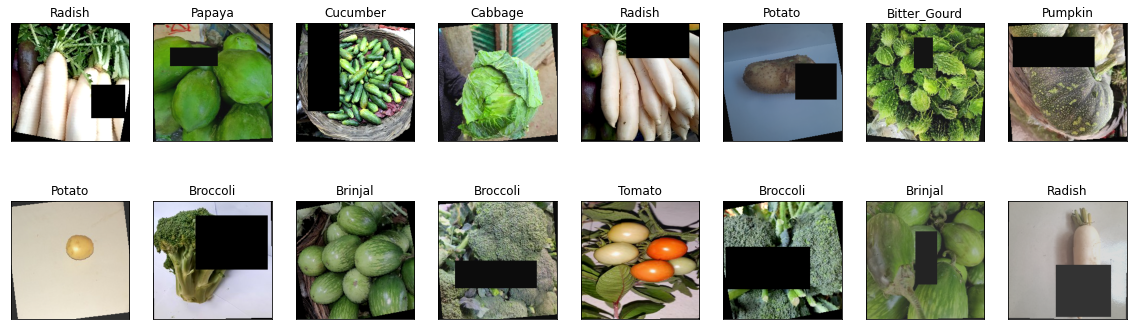

In [12]:
for images, labels, labels_one_hot in train_loader:
    print(f'The shape of a batch of images: {images.shape}')

    labels_print = labels[: 16]
    images_print = torch.permute(images[: 16], (0, 2, 3, 1)).detach().numpy()
    
    _, axs = plt.subplots(2, 8, figsize=(20, 6))
    axs = axs.flatten()

    i = 0
    for img, ax in zip(images_print, axs):
        ax.set_title(labels[i])

        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.imshow(img)
        i += 1
    plt.show()
    break

#### 9. Build DNN Model

Define the layers, neurons, and activation function.

##### 9.1 Model Structure
- Input layer: 1

- Hidden layers: 1 or 2

- Add batch normalization layer between each layer.

- Add dropout layer before the output layer.

- Add Sigmoid function at the output layer to make probabilities between 0 to 1.

- Activation function: ReLU (between hidden layers)

In [13]:
class VegetableMultiClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.num_classes = num_classes

        self.net = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=1),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(),
            
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Flatten(),

            # Replaced by following block
            nn.Linear(6400, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(4096, self.num_classes),
        )

        def _init_weights(m):
          if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

        self.net.apply(_init_weights)

    def forward(self, x):
        x = self.net(x)
        return x

#### 10. Load the Trained Model

In [14]:
model = VegetableMultiClassifier(num_classes)
model = torch.load('/AlexNet.pth')

#### 11. Output Distribution Analysis

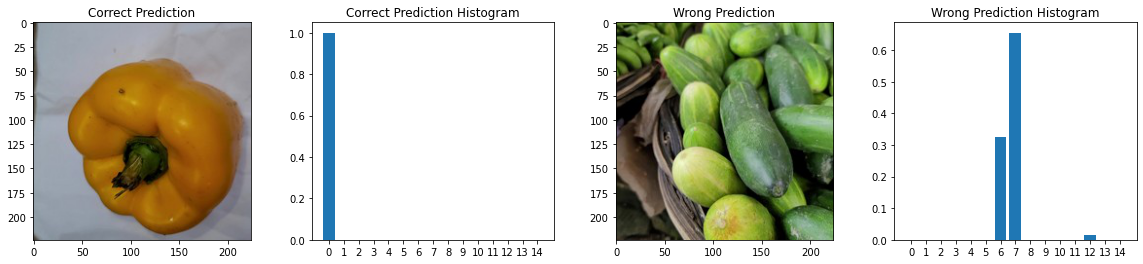

In [28]:
from scipy.special import softmax

model.eval()
with torch.no_grad():
    for features, labels, labels_one_hot in test_loader:
        features, labels_one_hot = features.to(device), labels_one_hot.to(device)

        pred_test = model(features)
        pred_print = torch.max(pred_test, 1)[1].cpu().numpy()

        label_print = labels_one_hot.cpu().numpy()
        feature_print = torch.permute(features, (0, 2, 3, 1)).detach().cpu().numpy()
        feature_print = np.squeeze(feature_print)

        _, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 4))

        count = 0
        for i in range(len(pred_print)):
            if pred_print[i] == label_print[i] and count != 0:
                ax1.imshow(feature_print[i])
                ax1.set_title('Correct Prediction')
                ax2.bar([str(t) for t in range(15)], softmax(pred_test[i].cpu().numpy()))
                ax2.set_title('Correct Prediction Histogram')
                count += 1
            if pred_print[i] != label_print[i]:
                ax3.imshow(feature_print[i])
                ax3.set_title('Wrong Prediction')
                ax4.bar([str(t) for t in range(15)], softmax(pred_test[i].cpu().numpy()))
                ax4.set_title('Wrong Prediction Histogram')
                count += 1
            if count == 2:
                break
        break

The histograms give us the Softmax probability to which the class the image belongs. For the correct prediction, the Softmax probability of the true category is much higher than the probabilities of other categories. On the other hand, the wrong prediction has multiple Softmax probabilities that have similar values.

#### 12. Feature Maps

Generally speaking, deep neural networks are black boxes to us. We do not understand the internal outputs of DNNs. However, by printing out feature maps of different convolutional layers, we can understand what representations, features and patterns they extract from the input image.

##### 12.1 Extract Conv2d Layers

Extract the Conv2d layers from the trained model and store them into a Python list.

In [16]:
def get_conv(model):
    conv_layers = []
    model_children = list(model.children())

    count = 0
    model_sub_children = list(model_children[0].children())

    for child in model_sub_children:
        if type(child) == nn.Conv2d or type(child) == nn.MaxPool2d:
            count += 1
            conv_layers.append(child)

    return conv_layers, count

##### 12.2 Generate Feature Maps

Pass an image into each layer and append the output and name of each layer to two Python lists.

In [17]:
def create_feature_map(model, data_loader, conv_layers):
    outputs = []
    names = []

    model.eval()
    with torch.no_grad():
        for features, labels, labels_one_hot in data_loader:
            features = features.to(device)
            
            feature_print = features[0: 1, :, :, :]
            org_input = features[0]

            for layer in conv_layers[0:]:
                feature_print = layer(feature_print)
                outputs.append(feature_print)
                names.append(str(layer))

            break
    return outputs, names, org_input

In [18]:
conv_layers, count = get_conv(model)
outputs, names, input_image = create_feature_map(model, test_loader, conv_layers)

In [19]:
for feature_map in outputs:
    print(feature_map.shape)

for name in names:
    print(name)

torch.Size([1, 96, 54, 54])
torch.Size([1, 96, 26, 26])
torch.Size([1, 256, 26, 26])
torch.Size([1, 256, 12, 12])
torch.Size([1, 384, 12, 12])
torch.Size([1, 384, 12, 12])
torch.Size([1, 256, 12, 12])
torch.Size([1, 256, 5, 5])
Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(1, 1))
MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)


##### 12.3 Input Image

(-0.5, 223.5, 223.5, -0.5)

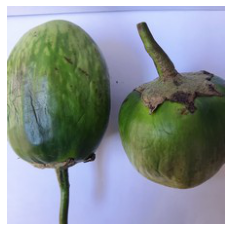

In [20]:
plt.imshow(torch.permute(input_image, (1, 2, 0)).detach().cpu().numpy())
plt.axis('off')

##### 12.4 Feature Maps of Conv2d and MaxPool2d Layers

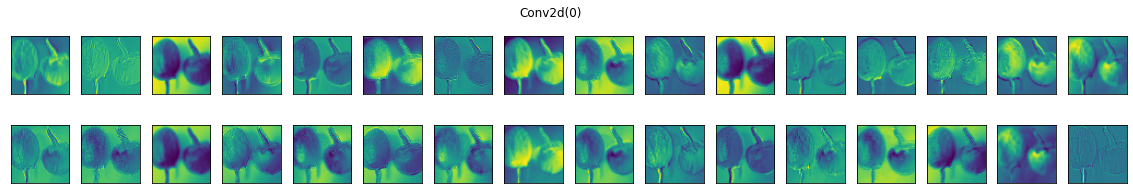

In [21]:
fig, axs = plt.subplots(2, 16, figsize=(20, 3))
fig.suptitle('Conv2d(0)')
axs = axs.flatten()

for ax, img in zip(axs, outputs[0][0]):
    ax.imshow(img.detach().cpu().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

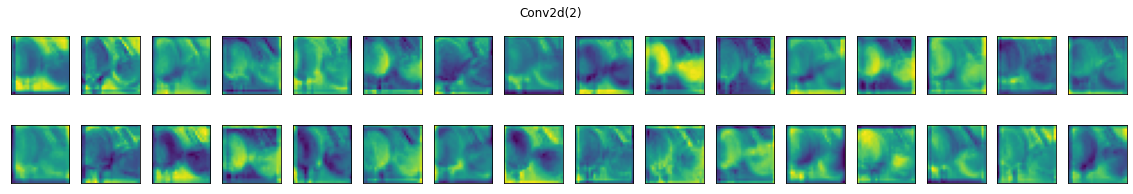

In [22]:
fig, axs = plt.subplots(2, 16, figsize=(20, 3))
fig.suptitle('Conv2d(2)')
axs = axs.flatten()

for ax, img in zip(axs, outputs[2][0]):
    ax.imshow(img.detach().cpu().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

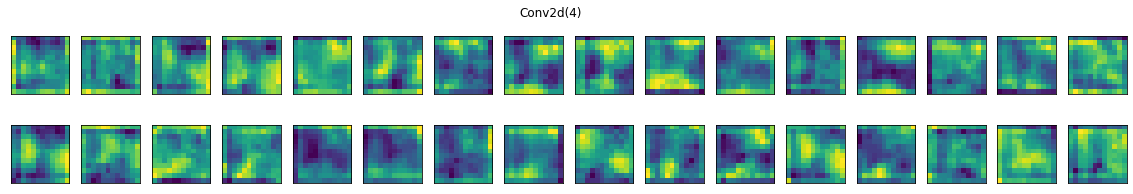

In [23]:
fig, axs = plt.subplots(2, 16, figsize=(20, 3))
fig.suptitle('Conv2d(4)')
axs = axs.flatten()

for ax, img in zip(axs, outputs[4][0]):
    ax.imshow(img.detach().cpu().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

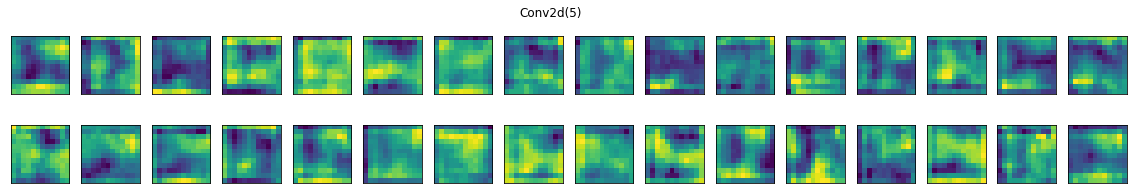

In [24]:
fig, axs = plt.subplots(2, 16, figsize=(20, 3))
fig.suptitle('Conv2d(5)')
axs = axs.flatten()

for ax, img in zip(axs, outputs[5][0]):
    ax.imshow(img.detach().cpu().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

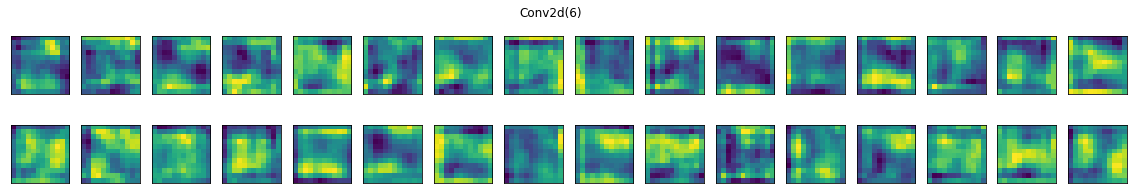

In [25]:
fig, axs = plt.subplots(2, 16, figsize=(20, 3))
fig.suptitle('Conv2d(6)')
axs = axs.flatten()

for ax, img in zip(axs, outputs[6][0]):
    ax.imshow(img.detach().cpu().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

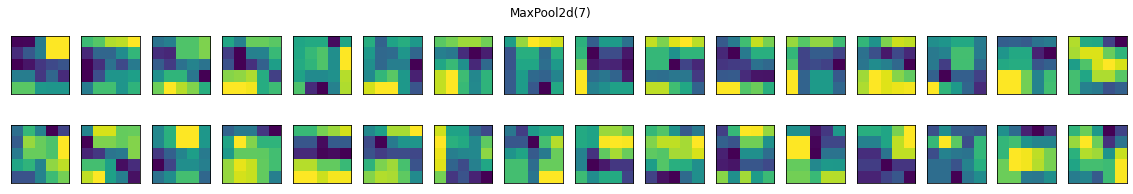

In [26]:
fig, axs = plt.subplots(2, 16, figsize=(20, 3))
fig.suptitle('MaxPool2d(7)')
axs = axs.flatten()

for ax, img in zip(axs, outputs[7][0]):
    ax.imshow(img.detach().cpu().numpy())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)